<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/ROI_insula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook serves as a quick check for the **control ROI, namely the insula.** I would like to better understand the ROI boundaries and how to split it into anterior and posterior.

In [33]:
#!pip install nilearn
from nilearn import datasets, plotting, image, masking
import numpy as np
import os
import nibabel as nib

In [3]:
# Load the MNI template brain for visualisation
mni = datasets.load_mni152_template()

# Jülich Atlas

# Inspect the Jülich Atlas Docs.

In [4]:
# Fetch probabilistic Jülich atlas (1 mm)
julich = datasets.fetch_atlas_juelich("prob-1mm")  # or "maxprob-thr50-1mm"
labels = julich.labels

[fetch_atlas_juelich] Added README.md to /root/nilearn_data

[fetch_atlas_juelich] Dataset created in /root/nilearn_data/fsl

[fetch_atlas_juelich] Downloading data from https://www.nitrc.org/frs/download.php/12096/Juelich.tgz ...

[fetch_atlas_juelich]  ...done. (1 seconds, 0 min)

[fetch_atlas_juelich] Extracting data from /root/nilearn_data/fsl/5f0f3de71552237df29d0de14db5f8c8/Juelich.tgz...

[fetch_atlas_juelich] .. done.

In [5]:
print("Number of labels:", len(labels))
for i, lab in enumerate(labels):
    if "Insula" in lab or "Id1" in lab or "Ig1" in lab or "Ig2" in lab:
        print(i, lab)

Number of labels: 63
21 GM Insula Id1
22 GM Insula Ig1
23 GM Insula Ig2


# Probabilistic Jülich Atlas

`"prob-1mm"`

In [6]:
# Helper function since without the background all indices are idx-1

def get_julich_roi(atlas_img, labels, query):
    """
    Retrieve a probabilistic ROI map from the Jülich atlas.

    Parameters
    ----------
    atlas_img : Nifti1Image
        The 4D probabilistic atlas (from fetch_atlas_juelich("prob-1mm")).
    labels : list of str
        Label names (includes "Background" at index 0).
    query : str
        Case-insensitive string to match (e.g. "subiculum").

    Returns
    -------
    roi_img : Nifti1Image
        The 3D probabilistic ROI image (values 0–100).
    idx : int
        The correct index in the 4D atlas (after Background correction).
    label : str
        The matched label string.
    """
    # Find label index (includes Background as [0])
    matches = [i for i, lab in enumerate(labels) if query.lower() in lab.lower()]
    if not matches:
        raise ValueError(f"No ROI found for query '{query}'.")

    # First match (you could extend this for multiple)
    label_idx = matches[0]
    map_idx = label_idx - 1  # Correct for Background
    if map_idx < 0:
        raise ValueError("Background is not a valid ROI.")

    roi_img = image.index_img(atlas_img, map_idx)
    return roi_img, map_idx, labels[label_idx]

In [7]:
# Function to split the ROI along the midline, which is x=0 in MNI space
# Other than in the HO atlas, the Jülich atlas does not automatically seperate the ROIs in LH and RH

def split_left_right(mask_img):
    """Split a bilateral ROI into left/right hemisphere masks."""
    data = mask_img.get_fdata()
    affine = mask_img.affine

    # Find voxel index corresponding to x=0
    x_voxel = int(round(np.linalg.inv(affine).dot([0, 0, 0, 1])[0]))

    left_data = np.zeros_like(data)
    right_data = np.zeros_like(data)

    left_data[:x_voxel, :, :] = data[:x_voxel, :, :]
    right_data[x_voxel:, :, :] = data[x_voxel:, :, :]

    left_img = image.new_img_like(mask_img, left_data, affine)
    right_img = image.new_img_like(mask_img, right_data, affine)
    return left_img, right_img

# Insula

In [8]:
# Extract all three insular subregions (Id1, Ig1, Ig2)

atlas_img = julich.maps  # 4D probabilistic atlas

insula_subregions = ["Id1", "Ig1", "Ig2"]
insula_imgs = []
for name in insula_subregions:
    roi_img, idx, label = get_julich_roi(atlas_img, labels, name)
    insula_imgs.append(roi_img)
    print(f"Loaded {label} (index {idx})")

Loaded GM Insula Id1 (index 20)
Loaded GM Insula Ig1 (index 21)
Loaded GM Insula Ig2 (index 22)


**Id1**

In [9]:
# Get Insula Id1 (bilateral)
id1_img, idx, label = get_julich_roi(atlas_img, labels, "Id1")
print(f"Loaded ROI: {label} (index {idx})")

Loaded ROI: GM Insula Id1 (index 20)


In [10]:
# Get Insula Id1 (bilateral)
id1_left, id1_right = split_left_right(id1_img)

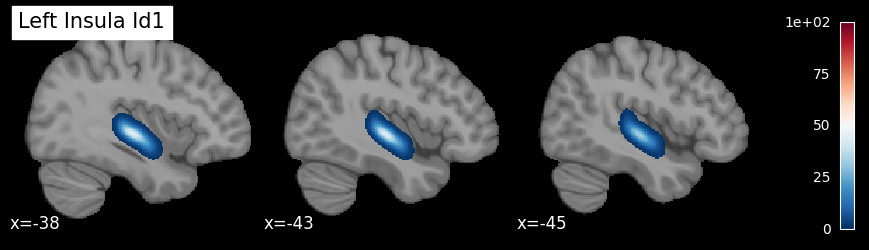

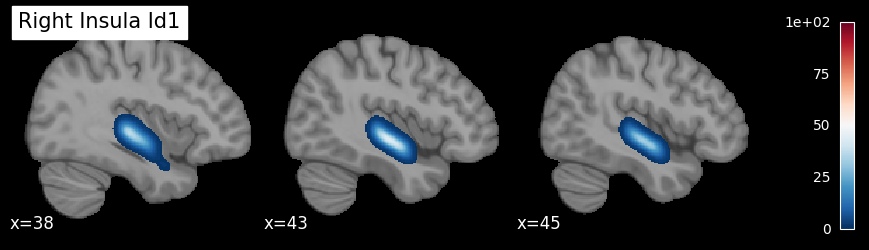

In [13]:
# Plot the insular Id1 in LH and RH
plotting.plot_stat_map(
    id1_left,
    bg_img=datasets.load_mni152_template(),
    title="Left Insula Id1",
    display_mode="x",
    cut_coords=[-38, -43, -45],
    threshold=0, vmax=100, draw_cross=False
)

plotting.plot_stat_map(
    id1_right,
    bg_img=datasets.load_mni152_template(),
    title="Right Insula Id1",
    display_mode="x",
    cut_coords=[38, 43, 45],
    threshold=0, vmax=100, draw_cross=False
)

plotting.show()

In [14]:
data = id1_img.get_fdata()
print(f"Min: {np.min(data):.1f}, Max: {np.max(data):.1f}")

Min: 0.0, Max: 50.0


**Ig1**

In [15]:
# Get Insula Ig1 (bilateral)
ig1_img, idx, label = get_julich_roi(atlas_img, labels, "Ig1")
print(f"Loaded ROI: {label} (index {idx})")

Loaded ROI: GM Insula Ig1 (index 21)


In [16]:
# Get Insula Ig1 (bilateral)
ig1_left, ig1_right = split_left_right(ig1_img)

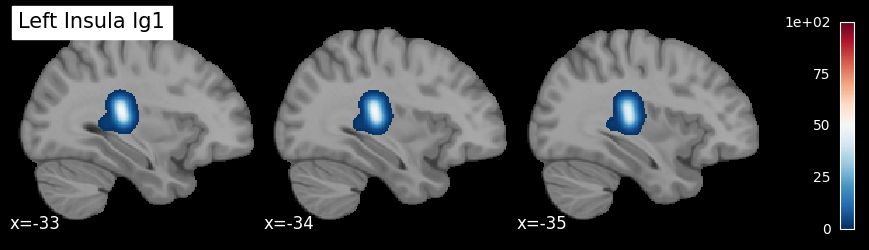

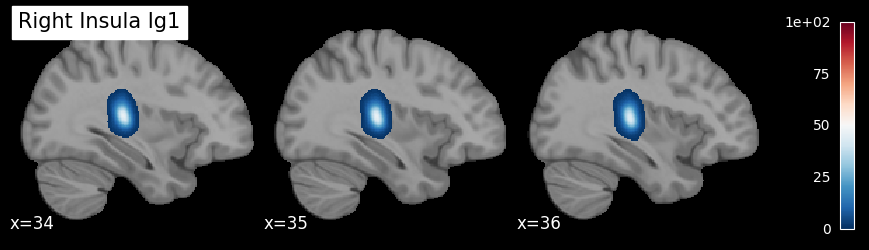

In [19]:
# Plot the insular Ig1 in LH and RH
plotting.plot_stat_map(
    ig1_left,
    bg_img=datasets.load_mni152_template(),
    title="Left Insula Ig1",
    display_mode="x",
    cut_coords=[-33, -34, -35],
    threshold=0, vmax=100, draw_cross=False
)

plotting.plot_stat_map(
    ig1_right,
    bg_img=datasets.load_mni152_template(),
    title="Right Insula Ig1",
    display_mode="x",
    cut_coords=[34, 35, 36],
    threshold=0, vmax=100, draw_cross=False
)

plotting.show()

In [24]:
data = ig1_img.get_fdata()
print(f"Min: {np.min(data):.1f}, Max: {np.max(data):.1f}")

Min: 0.0, Max: 50.0


**Ig2**

In [20]:
# Get Insula Ig2 (bilateral)
ig2_img, idx, label = get_julich_roi(atlas_img, labels, "Ig2")
print(f"Loaded ROI: {label} (index {idx})")

Loaded ROI: GM Insula Ig2 (index 22)


In [21]:
# Get Insula Ig1 (bilateral)
ig2_left, ig2_right = split_left_right(ig2_img)

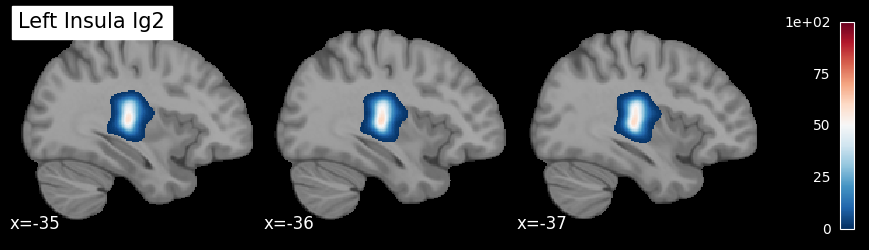

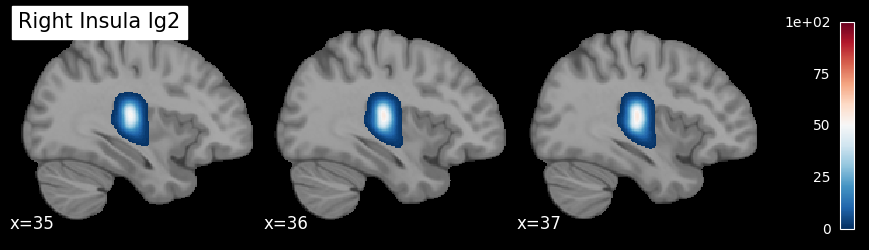

In [23]:
# Plot the insular Ig2 in LH and RH
plotting.plot_stat_map(
    ig2_left,
    bg_img=datasets.load_mni152_template(),
    title="Left Insula Ig2",
    display_mode="x",
    cut_coords=[-35, -36, -37],
    threshold=0, vmax=100, draw_cross=False
)

plotting.plot_stat_map(
    ig2_right,
    bg_img=datasets.load_mni152_template(),
    title="Right Insula Ig2",
    display_mode="x",
    cut_coords=[35, 36, 37],
    threshold=0, vmax=100, draw_cross=False
)

plotting.show()

In [25]:
data = ig2_img.get_fdata()
print(f"Min: {np.min(data):.1f}, Max: {np.max(data):.1f}")

Min: 0.0, Max: 61.0


# Combining Id1, Ig1 and Ig2 into one brain mask

In [131]:
julich_img = julich.maps
julich_data = julich_img.get_fdata()

In [132]:
threshold = 0

In [133]:
Id1_idx = labels.index("GM Insula Id1") - 1
Ig1_idx = labels.index("GM Insula Ig1") - 1
Ig2_idx = labels.index("GM Insula Ig2") - 1

In [134]:
Id1 = (julich_data[..., Id1_idx] > threshold)
Ig1 = (julich_data[..., Ig1_idx] > threshold)
Ig2 = (julich_data[..., Ig2_idx] > threshold)

# This now returns a 3D boolean array
I = Id1 | Ig1 | Ig2

/tmp/ipython-input-1364157888.py:7: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  I_mask_resampled = image.resample_to_img(I_mask_img, mni_img, interpolation='nearest')
/tmp/ipython-input-1364157888.py:7: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  I_mask_resampled = image.resample_to_img(I_mask_img, mni_img, interpolation='nearest')


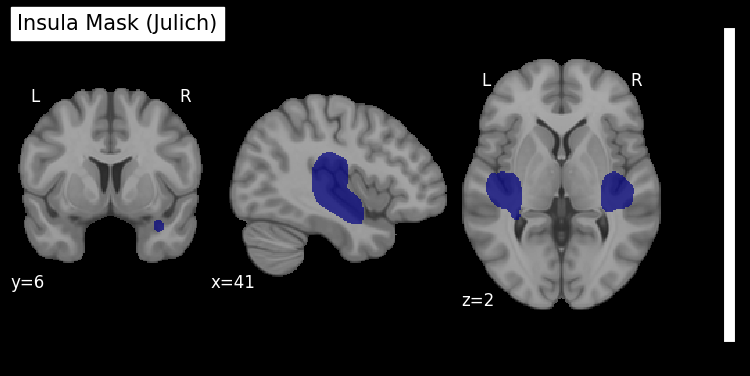

In [130]:
mni_img = datasets.load_mni152_template() #By default, the MNI 152 template has a resolution of 1mm #Important: our data is in 3mm isotropic resolution

# Step 2: Convert your I mask to a NIfTI image
I_mask_img = nib.Nifti1Image(I.astype(np.uint8), affine=julich_img.affine)

# Step 3: Resample the mask to match the MNI template (if needed)
I_mask_resampled = image.resample_to_img(I_mask_img, mni_img, interpolation='nearest')

# Step 4: Plot the mask over the MNI template
plotting.plot_roi(I_mask_resampled, bg_img=mni_img, title="Insula Mask (Julich)", cut_coords=[41, 6, 2], draw_cross=False)
plotting.show()

Comment: the problem with the insula is that when I set the probabilistic threshold to 50, there are almost no voxels included. This means that the mask doesn't even become visible when overlaid onto the MNI 152 template brain.

In [136]:
print(julich_img.affine)
print(mni.affine)

[[   1.    0.    0.  -91.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
[[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


In [139]:
import numpy as np
from nilearn.image import coord_transform

# Get data and affine from your final mask (use the same one you’ll actually analyse)
mask_data = I_mask_img.get_fdata()   # or I_mask_resampled.get_fdata() if you prefer
affine = I_mask_img.affine

# Get voxel indices where mask == 1
voxel_indices = np.argwhere(mask_data > 0)

# Transform voxel indices into MNI coordinates
mni_coords = np.asarray([
    coord_transform(x, y, z, affine)
    for x, y, z in voxel_indices
])

# Extract all y-coordinates (2nd column)
y_coords = mni_coords[:, 1]

# Print min/max and maybe a few percentiles for reference
print(f"Insula mask y-range: {y_coords.min():.1f} mm  to  {y_coords.max():.1f} mm")
print(f"25th, 50th, 75th percentiles: {np.percentile(y_coords, [25, 50, 75])}")

Insula mask y-range: -44.0 mm  to  7.0 mm
25th, 50th, 75th percentiles: [-27. -20. -13.]


# Segmenting the Insula into anterior-posterior gradient

(and into left and right)

In [140]:
def segmentInsulaX(mask, x_index):
  # This function segments the mask along the x axis, into left and right.
  # Note: mask is a 3D boolean array.
  # In the MNI, the midline corresponds to x=0. However, we need to convert it
  # into voxel coordinates.
  # The output is a dictionary with two keys (left and right).

  right = mask.copy() # I use copy to avoid getting views of variables
  left = mask.copy()

  right[:x_index,:,:] = 0
  # then y_index is set to 0 (and discarded)
  end = mask.shape[0]
  left[x_index:end,:,:] = 0

  return {'left': left,
          'right': right}

In [141]:
def segmentInsulaY(mask, y_index_anterior, y_index_posterior):
    """
    Segment a hippocampal mask into anterior and posterior portions
    with an optional gap between y_index_posterior and y_index_anterior.

    Parameters
    ----------
    mask : 3D boolean array
        #Full hippocampal mask in MNI space.
    y_index_anterior : int
        #Voxel index corresponding to the *start* of the anterior portion (e.g., y = -18).
    y_index_posterior : int
        #Voxel index corresponding to the *end* of the posterior portion (e.g., y = -24).

    Returns
    -------
    dict
        {'anterior': anterior_mask, 'posterior': posterior_mask}
    """
    anterior_mask = mask.copy()
    posterior_mask = mask.copy()

    end = mask.shape[1]

    # posterior: keep y < y_index_posterior
    posterior_mask[:, y_index_posterior:end, :] = 0

    # anterior: keep y > y_index_anterior
    anterior_mask[:, :y_index_anterior, :] = 0

    return {'posterior': posterior_mask,
            'anterior': anterior_mask}

In [143]:
mni_x = 0
affine = julich_img.affine
inv_affine = np.linalg.inv(affine) # transform MNI coordinate into matrix indexes
x_index, _, _ = np.round(inv_affine @ np.array([mni_x, 0, 0, 1])).astype(int)[:3]

# Fill masks
# Anterior = voxels in hippocampus labels at y >= y_index
sagittal_segmentation = segmentInsulaX(I, x_index)

In [144]:
# Convert y = -18 and y = -24 MNI coordinates to voxel indices
mni_y = [-18, -20]  # new anterior/posterior boundaries
affine = julich_img.affine
inv_affine = np.linalg.inv(affine)  # transform MNI coordinates into matrix indices

# Compute voxel indices for both y values
_, y_index_anterior, _ = np.round(inv_affine @ np.array([0, mni_y[0], 0, 1])).astype(int)[:3]
_, y_index_posterior, _ = np.round(inv_affine @ np.array([0, mni_y[1], 0, 1])).astype(int)[:3]

# Fill masks: segment each hemisphere mask into anterior/posterior parts
masks = {
    h: segmentInsulaY(seg, y_index_anterior, y_index_posterior)
    for h, seg in sagittal_segmentation.items()
}

# Convert each resulting ROI to a NIfTI image
masks_img = {
    h: {
        roi: nib.Nifti1Image(arr.astype(np.uint8), affine)
        for roi, arr in rois.items()
    }
    for h, rois in masks.items()
}

In [146]:
import matplotlib.colors as mcolors

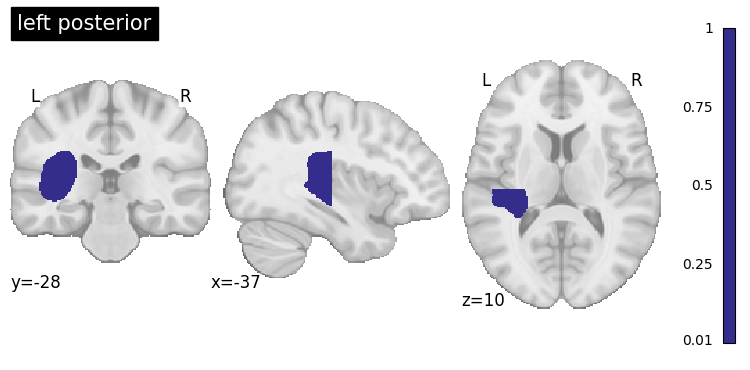

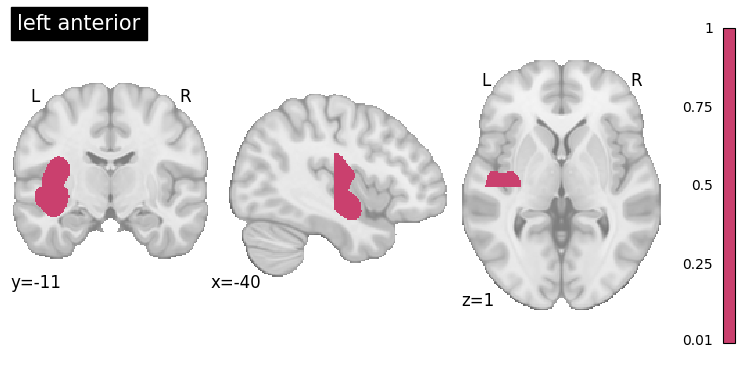

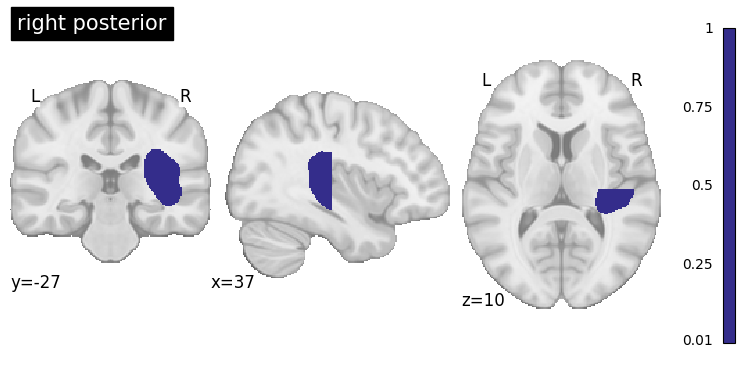

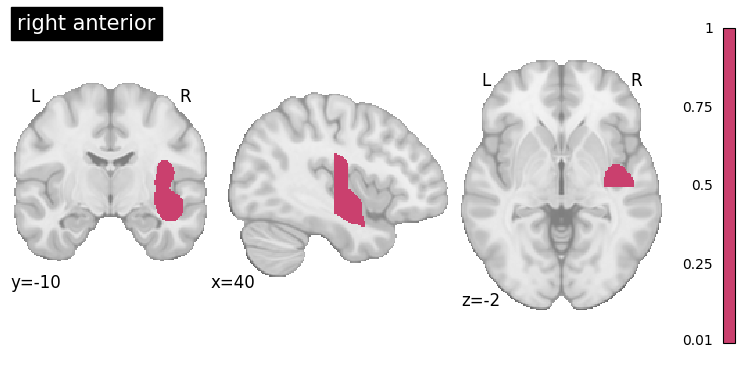

In [147]:
# Check: visualize the longitudinal axis segmentation
colors = {"posterior": '#342d8bff',
          "anterior": '#ca406eff'}
for h in masks_img:
  for roi in masks_img[h]:
    plotting.plot_stat_map(
        masks_img[h][roi],
        bg_img=mni_img,
        draw_cross=False,
        threshold=0.01,
        black_bg=False,
        colorbar=True,
        cmap=mcolors.ListedColormap([[0, 0, 0, 0], colors[roi]]),
        vmin=0,
        vmax=1,
        title=h + " " + roi
    )
  plotting.show()